# Landslide Prediction Challenge

## 1. Import libraries

In [1]:
import os

import pandas as pd
import numpy as np
from IPython.display import Image
from IPython.core.display import HTML 
import statistics

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)

## 2. Description

[Ссылка на соревнование](https://zindi.africa/competitions/landslide-prevention-and-innovation-challenge) \
Задача бинарной классификации, необходимо по имеющейся информации о местности Гонконга предсказать будет ли оползень или нет.

Label-таргет-метка:
- 1-был оползень в заданной местности
- 0-не было оползня

Оценка производится по метрике **f1**.

Каждая строка представляет собой описание местности 25х25 метров. Каждый признак имеет 25 иттераций, \
таким образом в строке описано 25 местностей площадью 5х5 метров. Если хотя бы в одном из этих \
25 местностей был оползень, тагрет метка принимает 1.\
![alt text](image1.png "Пример")

**Описание полей:**

- elevation-Цифровая высота поверхности местности в метрах

- slope-Угол наклона склона в градусах

- aspect-Экспозиция наклона в градусах

- placurv-Кривизна в плане, кривизна, перпендикулярная направлению максимального уклона

- procurv-Кривизна профиля, кривизна, параллельная уклону, указывающая направление максимального уклона

- lsfactor-Коэффициент длины и крутизны склона (LS-фактор)

- twi-Топографический индекс влажности, индекс для количественной оценки топографического контроля гидрологического процесса

- geology-Литология поверхностного материала

    - 1: Выветрелые гранитные породы мелового периода.

    - 2: Выветренные юрские гранитные породы.

    - 3: Выветрелый юрский туф и лава

    - 4: Выветрелый меловой туф и лава.

    - 5: Четвертичные отложения

    - 6: Заполнить

    - 7: выветрившиеся юрские песчаники, алевролиты и аргиллиты.

- sdoif-Фактор усиления орографии продолжительностью шага: индекс для количественной оценки усиления 
орографии при выпадении осадков.

## 3. Load files

In [3]:
df = pd.read_csv('Train.csv')

## 4. Preview files

In [4]:
#Смотрим первые строки
df.head()

,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,...,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif,Label
0,1,130,129,127,126,123,126,125,124,122,...,1.281779,1.281743,1.281720,1.281684,1.281811,1.281788,1.281752,1.281729,1.281693,0
1,2,161,158,155,153,151,162,159,155,153,...,1.359639,1.359608,1.359587,1.359556,1.359683,1.359662,1.359631,1.359610,1.359579,1
2,3,149,151,154,156,158,154,157,158,160,...,1.365005,1.365025,1.365055,1.365075,1.364937,1.364967,1.364988,1.365018,1.365038,0
3,4,80,78,77,75,73,80,78,77,75,...,1.100708,1.100738,1.100759,1.100789,1.100630,1.100650,1.100680,1.100700,1.100731,0
4,5,117,115,114,112,110,115,113,111,110,...,1.284180,1.284130,1.284056,1.284006,1.284125,1.284050,1.284001,1.283926,1.283876,0


In [5]:
#Размер датасета
df.shape

(10864, 227)

In [6]:
#Проверка на пропуски в данных и дубликаты
df.isnull().sum().any(), df.duplicated().any()

(False, False)

In [7]:
df.describe()

,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,...,17_sdoif,18_sdoif,19_sdoif,20_sdoif,21_sdoif,22_sdoif,23_sdoif,24_sdoif,25_sdoif,Label
count,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,...,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000,10864.000000
mean,5432.500000,225.017489,224.925074,224.801730,224.673417,224.586156,225.050994,224.940630,224.792710,224.655468,...,1.301055,1.301038,1.301020,1.301000,1.301055,1.301036,1.301018,1.301001,1.300983,0.250000
std,3136.310996,158.419265,158.337494,158.264168,158.217713,158.185548,158.421040,158.333362,158.253865,158.201409,...,0.051938,0.051922,0.051905,0.051888,0.051981,0.051965,0.051949,0.051932,0.051916,0.433033
min,1.000000,3.000000,3.000000,4.000000,2.000000,1.000000,3.000000,4.000000,4.000000,2.000000,...,1.092410,1.092404,1.092393,1.092387,1.092354,1.092344,1.092337,1.092326,1.092320,0.000000
25%,2716.750000,101.750000,101.000000,101.000000,101.000000,101.000000,102.000000,101.000000,101.000000,101.000000,...,1.286458,1.286418,1.286371,1.286364,1.286440,1.286447,1.286387,1.286365,1.286335,0.000000
50%,5432.500000,191.000000,192.000000,192.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,...,1.308175,1.308136,1.308103,1.308072,1.308206,1.308184,1.308142,1.308116,1.308085,0.000000
75%,8148.250000,312.000000,311.250000,312.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,...,1.331691,1.331653,1.331616,1.331562,1.331760,1.331731,1.331665,1.331633,1.331575,0.250000
max,10864.000000,901.000000,904.000000,907.000000,909.000000,912.000000,905.000000,908.000000,910.000000,910.000000,...,1.370620,1.370627,1.370631,1.370637,1.370607,1.370612,1.370618,1.370623,1.370629,1.000000


## 5. EDA

### 5.1. Гипотеза 1 - Есть дисблаланс классов в сторону 0

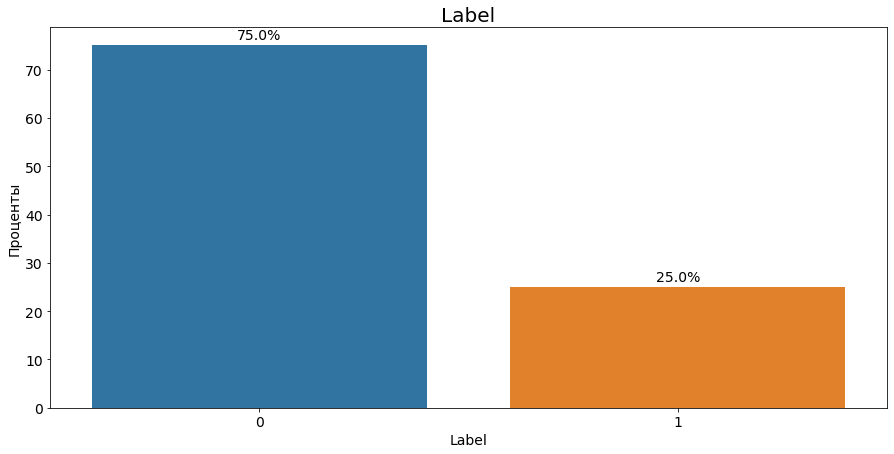

In [9]:
norm_target = (df
               .Label
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(15, 7))
ax = sns.barplot(x='index', y='percent', data=norm_target)

# Вывод значений над графиками - annotate()
# В цикле смотрим каждый столбец графика и на нем отмечаем значения
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                # координата xy
                (p.get_x() + p.get_width() / 2., p.get_height()),  
                # центрирование
                ha='center', 
                va='center',
                xytext=(0, 10),
                # точка смещения относительно координаты
                textcoords='offset points', 
                fontsize=14)

plt.title('Label', fontsize=20)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Гипотеза подтвердилась. Видим небольшой дисбаланс классов в сторону 0

### 5.2. Гипотеза 2 - Есть линейные зависимости таргета от признаков

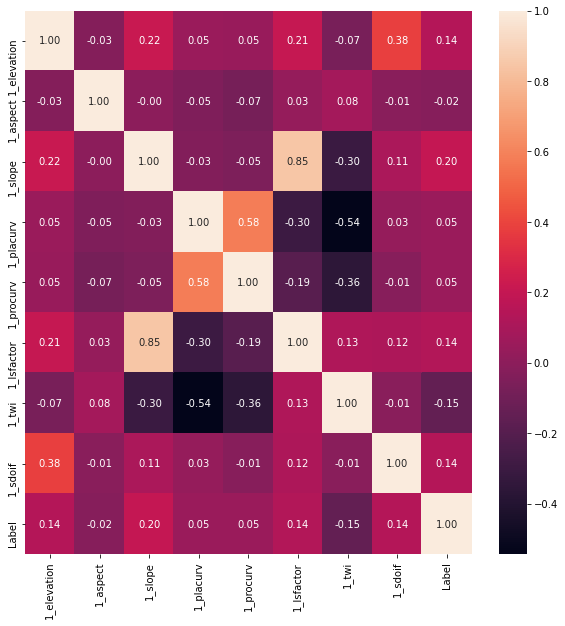

In [12]:
explore_cols =  ['1_elevation', '1_aspect', '1_slope', '1_placurv', 
                 '1_procurv', '1_lsfactor', '1_twi', '1_sdoif', 'Label']
plt.figure(figsize=(10, 10))
sns.heatmap(df[explore_cols].corr(method='spearman'), annot=True, fmt='.2f');

Гипотеза не подтвердилась. Видим, что есть сильная корреляция 
между признаками slope и Isfactor, но нет между признаками и таргетом. 
Значит скорее всего линейные алгоритмы справляться будут плохо

### 5.3. Гипотеза 3 - Есть зависимость таргета от типа гелогической местности

In [13]:
def boxplot_group(col_main: str, col_group: str, title: str) -> None:
    
    plt.figure(figsize=(15, 7))

    data = (df.groupby([col_group])[col_main]
            .value_counts(normalize=True)
            .rename('percentage')
            .mul(100)
            .reset_index()
            .sort_values(col_group))

    ax = sns.barplot(x=col_main, y="percentage", hue=col_group, data=data, palette='rocket')

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(percentage,  # текст
                    (p.get_x() + p.get_width() / 2.,
                     p.get_height()),  # координата xy
                    ha='center',  # центрирование
                    va='center',
                    xytext=(0, 10),
                    textcoords='offset points',  # точка смещения относительно координаты
                    fontsize=14)

    plt.title(title, fontsize=20)
    plt.ylabel('Percentage', fontsize=14)
    plt.xlabel(col_main, fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

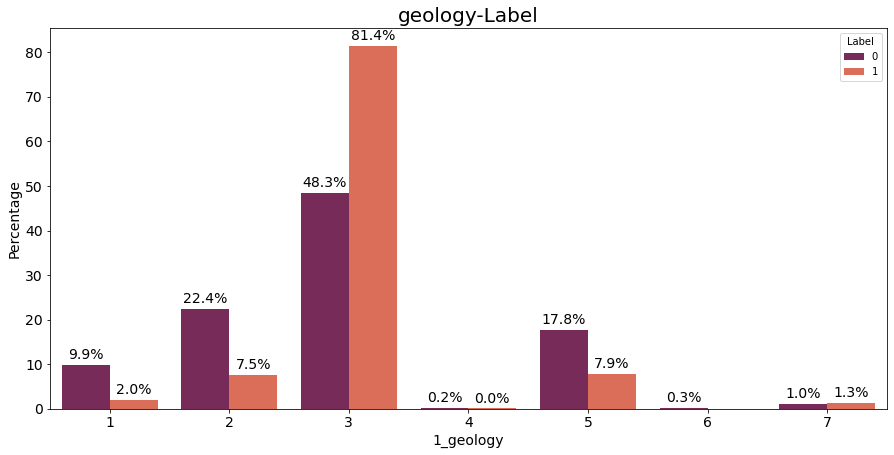

In [14]:
boxplot_group('1_geology', 'Label', 'geology-Label')

Гипотеза подтвердилась
Видим, что от Литологии поверхностного материала сильно зависит распределение нашего таргета.
Выветрелый юрский туф и лава(3) занимает 81,4% всех оползней
Помимо этого, в этой категории преобладает вероятность оползня, чем его отсутствие

### 5.4. Проверка на выбросы данных

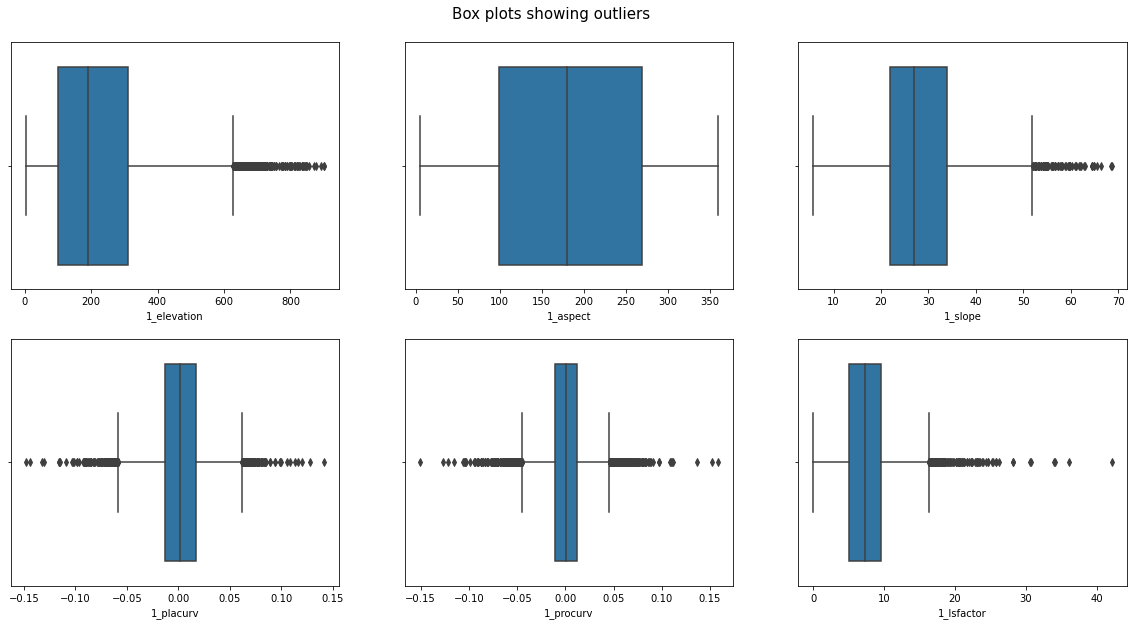

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
fig.suptitle('Box plots showing outliers', y=0.93, fontsize=15)

for ax, data, name in zip(axes.flatten(), df, explore_cols):
    sns.boxplot(df[name], ax=ax)

У призаков elevation, Isfactor, placurv, curve и slope есть выбросы. Признак aspect без выбросов.

### 5.5. Проверка на корреляцию между признаками

<Figure size 1440x864 with 0 Axes>

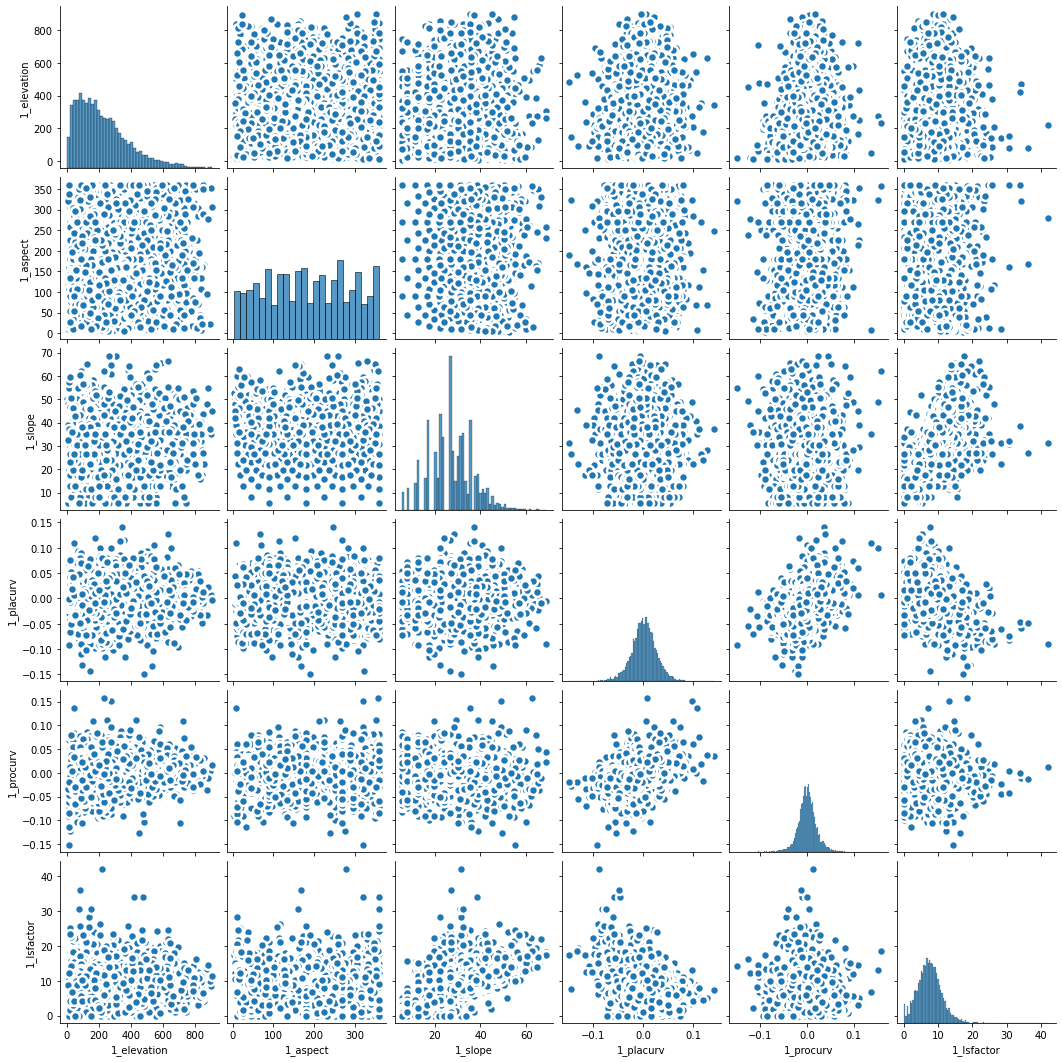

In [16]:
explore_cols2 =  ['1_elevation', '1_aspect', '1_slope', '1_placurv', 
                  '1_procurv', '1_lsfactor']
plt.figure(figsize = (20, 12))
sns.pairplot(df[explore_cols2], kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

Еще раз обратим внимание на отсутствие больших корреляций между признаками

## 6. Feature Engineering 

In [94]:
class FeatureEngineering:
    def __init__(self, data: pd.DataFrame):
        self.data = data
        self.df_train = pd.DataFrame()
        self.selectedCols = [
            'elevation', 'lsfactor', 'placurv', 'procurv', 'sdoif', 'slope',
            'twi', 'aspect'
        ]
        self.geology = [
            '1_geology', '2_geology', '3_geology', '4_geology', '5_geology',
            '6_geology', '7_geology', '8_geology', '9_geology', '10_geology',
            '11_geology', '12_geology', '13_geology', '14_geology',
            '15_geology', '16_geology', '17_geology', '18_geology',
            '19_geology', '20_geology', '21_geology', '22_geology',
            '23_geology', '24_geology', '25_geology'
        ]
        self.geology_full = [
            '1_geology', '2_geology', '3_geology', '4_geology', '5_geology',
            '6_geology', '7_geology', '8_geology', '9_geology', '10_geology',
            '11_geology', '12_geology', '13_geology', '14_geology',
            '15_geology', '16_geology', '17_geology', '18_geology',
            '19_geology', '20_geology', '21_geology', '22_geology',
            '23_geology', '24_geology', '25_geology', 'mode_geology'
        ]

    def feature_engineering(self) -> pd.DataFrame:
        for i in selectedCols:
            self.df_train[i + "_min"] = self.data[[
                x for x in df.columns if i in x
            ]].min(axis=1)
            self.df_train[i + "_max"] = self.data[[
                x for x in df.columns if i in x
            ]].max(axis=1)
            self.df_train[i + "_range"] = self.df_train[
                i + "_max"] - self.df_train[i + "_min"]

        self.data['mode_geology'] = self.data.apply(
            lambda x: int(statistics.mode(x[geology])), axis=1)
        for col in self.data.columns:
            if col in geology_full:
                self.data[col] = self.data[col].astype('category')

        df_concat = pd.concat([self.data, self.df_train], axis=1)

        return df_concat


class FeatureEngineeringBin(FeatureEngineering):
    def feature_engineering_bin(self) -> pd.DataFrame:

        return pd.get_dummies(self.feature_engineering(), drop_first=True)

In [95]:
s = FeatureEngineering(df)
df_train = s.feature_engineering()
df_train

,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,...,sdoif_range,slope_min,slope_max,slope_range,twi_min,twi_max,twi_range,aspect_min,aspect_max,aspect_range
0,1,130,129,127,126,123,126,125,124,122,...,0.000162,30.24626,45.83452,15.58826,2.915506,4.218082,1.302576,97.12502,135.0000,37.87498
1,2,161,158,155,153,151,162,159,155,153,...,0.000220,21.80141,35.26439,13.46298,4.109311,5.175152,1.065841,168.69010,198.4350,29.74490
2,3,149,151,154,156,158,154,157,158,160,...,0.000224,21.80141,56.77032,34.96891,2.413693,5.951684,3.537991,248.19860,310.6013,62.40270
3,4,80,78,77,75,73,80,78,77,75,...,0.000393,15.79317,30.24626,14.45309,3.015849,4.421484,1.405635,135.00000,213.6901,78.69010
4,5,117,115,114,112,110,115,113,111,110,...,0.000682,22.98977,32.63194,9.64217,3.523277,5.617533,2.094256,116.56500,135.0000,18.43500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,10860,203,202,201,200,199,202,201,201,199,...,0.000959,12.60438,30.24626,17.64188,3.183432,5.979714,2.796282,90.00000,153.4350,63.43500
10860,10861,432,430,427,423,421,431,429,426,422,...,0.000229,19.82703,36.05503,16.22800,3.042458,4.385803,1.343345,101.30990,180.0000,78.69010
10861,10862,348,345,342,339,335,344,342,339,336,...,0.000153,35.26439,44.71062,9.44623,2.940966,4.451507,1.510541,125.53770,150.2551,24.71740
10862,10863,93,91,90,88,86,96,94,93,92,...,0.000420,26.56505,42.67464,16.10959,2.963617,4.638149,1.674532,219.80560,270.0000,50.19440


In [96]:
v = FeatureEngineeringBin(df)
df_train_bin = v.feature_engineering_bin()
df_train_bin

,Sample_ID,1_elevation,2_elevation,3_elevation,4_elevation,5_elevation,6_elevation,7_elevation,8_elevation,9_elevation,...,25_geology_4,25_geology_5,25_geology_6,25_geology_7,mode_geology_2,mode_geology_3,mode_geology_4,mode_geology_5,mode_geology_6,mode_geology_7
0,1,130,129,127,126,123,126,125,124,122,...,0,0,0,0,0,1,0,0,0,0
1,2,161,158,155,153,151,162,159,155,153,...,0,0,0,0,0,1,0,0,0,0
2,3,149,151,154,156,158,154,157,158,160,...,0,0,0,0,1,0,0,0,0,0
3,4,80,78,77,75,73,80,78,77,75,...,0,0,0,0,1,0,0,0,0,0
4,5,117,115,114,112,110,115,113,111,110,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10859,10860,203,202,201,200,199,202,201,201,199,...,0,0,0,0,1,0,0,0,0,0
10860,10861,432,430,427,423,421,431,429,426,422,...,0,0,0,0,0,1,0,0,0,0
10861,10862,348,345,342,339,335,344,342,339,336,...,0,0,0,0,0,1,0,0,0,0
10862,10863,93,91,90,88,86,96,94,93,92,...,0,0,0,0,1,0,0,0,0,0


In [98]:
df_train.to_csv('df_train.csv', index = False)

In [99]:
df_train_bin.to_csv('df_train_bin.csv', index = False)